# Deep Learning/Computer vision - Project 3
Bogna Kilanowska 148252 <br> Zuzanna Buchnajzer 148280

### 1 Read data

In [1]:
import cv2
from zipfile import ZipFile
import zipfile

In [2]:
# only for google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = cv2.imshow

In [3]:
# only when it is necesary to load data from zip file
'''
#unpack images
with ZipFile('dixit_rgb.zip', 'r') as zipObj:
   zipObj.extractall('dixit_rgb')
'''

"\n#unpack images\nwith ZipFile('dixit_rgb.zip', 'r') as zipObj:\n   zipObj.extractall('dixit_rgb')\n"

In [4]:
#loading images using the opencv library
files = []

img_name = './rgb/img_rgb n.jpg'

for i in range(1000):
  name = img_name.replace('n', str(i))
  files.append(name)

#load images
dixit_rgb = [cv2.imread(x, 1) for x in files]

In [5]:
files.clear()

### 2 Display images

In [6]:
import matplotlib as plt
import matplotlib.pyplot as plot

In [7]:
def show_img(img):
    plot.axis("off")
    plot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plot.show()

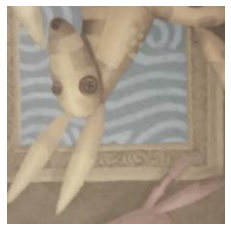

In [8]:
show_img(dixit_rgb[78])

### 3 Data Augmentation


In [9]:
import numpy as np

In [10]:
#Flip vertically
flipped_v_rgb = [cv2.flip(x, 0) for x in dixit_rgb]

#Flip horizontaly
flipped_h_rgb = [cv2.flip(x, 1) for x in dixit_rgb]

In [11]:
#Combine lists into one dataset
dataset = dixit_rgb + flipped_v_rgb + flipped_h_rgb
print(len(dataset))

3000


In [12]:
#Change lightning
bright_rgb = [cv2.convertScaleAbs(x, beta = 20) for x in dataset]
dark_rgb = [cv2.convertScaleAbs(x, beta = -20) for x in dataset]

In [13]:
#Combine lists into one dataset
dataset = dixit_rgb + flipped_v_rgb + flipped_h_rgb + bright_rgb + dark_rgb
print(len(dataset))

9000


In [14]:
#Clear lists
flipped_h_rgb.clear()
flipped_v_rgb.clear()
bright_rgb.clear()
dark_rgb.clear()
dixit_rgb.clear()

### 4 Data Preprocessing

In [15]:
from skimage.color import rgb2lab, lab2rgb

In [16]:
#number of images to get from dataset
n = 1500
test_n = int(n/10)

In [17]:
#Fix image sizes
dataset = [cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA) for img in dataset]

#Change from bgr to rgb
dataset = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in dataset]

In [18]:
np.random.seed(244)
data_id = np.arange(len(dataset))
np.random.shuffle(data_id)

In [19]:
test_id = data_id[n:test_n + n]
data_id = data_id[:n]

In [20]:
#Convert RGB to LAB
#dataset_lab = [rgb2lab(img) for img in dixit_rgb]

#Split Lab data into x(input) and y(target)
#x has only information about l (the brightnes of the image)
#y has only information about a, b (the colour channels of the image)
x = []
y = []

for i in data_id:
    x.append(rgb2lab(dataset[i])[:,:,0])
    y.append(rgb2lab(dataset[i])[:,:,1:]/128)

#x = [(rgb2lab(img)[:,:,0]) for img in dataset[:n]]
#y = [(rgb2lab(img)[:,:,1:])/128 for img in dataset[:n]]

In [21]:
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape+(1,)) #dimensions to be the same for X and Y

In [22]:
#Create test dataset
test_x = []
test_y = []

for i in test_id:
    test_x.append(rgb2lab(dataset[i])[:,:,0])
    test_y.append(rgb2lab(dataset[i])[:,:,1:]/128)

In [23]:
test_x = np.array(test_x)
test_y = np.array(test_y)
test_x = test_x.reshape(test_x.shape+(1,)) #dimensions to be the same for X and Y

In [24]:
test_id = list(test_id)
data_id = list(data_id)
test_id.clear()
data_id.clear()
dataset.clear()

In [25]:
def show_lab_img(x, y):

    plot.axis("off")

    img = np.zeros((224, 224, 3))
    x = np.squeeze(x)
    y = y*128
    
    img[:,:,0] = x
    img[:,:,1] = y[:,:,0]
    img[:,:,2] = y[:,:,1]
    img = lab2rgb(img)
    img = np.float32(img)

    plot.imshow(img)
    plot.show()

(1500, 224, 224, 1)
(1500, 224, 224, 2)
(150, 224, 224, 1)
(150, 224, 224, 2)


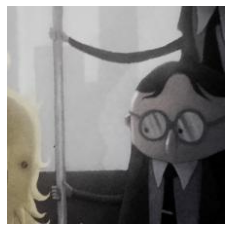

In [26]:
print(x.shape)
print(y.shape)
print(test_x.shape)
print(test_y.shape)
show_lab_img(x[4], y[4])

### 5 Train and validation sets

In [27]:
np.random.seed(244)
k = 5

In [28]:
id_list = np.arange(n)
np.random.shuffle(id_list)
id_list = np.reshape(id_list, (k, int(n/k)))

In [29]:
def split_id(val_row_id):

    train_id_pom = []
    for i in range(k):
        if not(i == val_row_id):
            for j in id_list[i]:
                train_id_pom.append(j)
            
    train_id = np.array(train_id_pom)
    val_id = id_list[val_row_id]

    train_id_pom.clear()
    
    return train_id, val_id

### 6 Model

In [30]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input

2023-01-25 07:29:04.445573: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-25 07:29:04.445601: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-25 07:29:06.043875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-25 07:29:06.044070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-25 07:29:06.044085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [ ]:
'''
inputs = Input((224, 224, 1))

#Encoder
s1 = Conv2D(32, 3, activation = "relu", padding = 'same')(inputs)
s1 = Conv2D(32, 3, activation = "relu", padding = 'same')(s1)
p1 = MaxPooling2D(pool_size=(2,2))(s1)

s2 = Conv2D(64, 3, activation = "relu", padding = 'same')(p1)
s2 = Conv2D(64, 3, activation = "relu", padding = 'same')(s2)
p2 = MaxPooling2D(pool_size=(2,2))(s2)

s3 = Conv2D(128, 3, activation = "relu", padding = 'same')(p2)
s3 = Conv2D(128, 3, activation = "relu", padding = 'same')(s3)
p3 = MaxPooling2D(pool_size=(2,2))(s3)

#Scope
b1 = Conv2D(256, 3, activation = "relu", padding = 'same')(p3)
b1 = Conv2D(256, 3, activation = "relu", padding = 'same')(b1)

#Decoder
d1 = Conv2D(128, 2, activation = "relu", padding = 'same')(UpSampling(size = (2,2))(b1))
d1 = concatenate([s3, d1], axis = 3)
d1 = Conv2D(128, 3, activation = "relu", padding = 'same')(d1)
d1 = Conv2D(128, 3, activation = "relu", padding = 'same')(d1)

d2 = Conv2D(64, 2, activation = "relu", padding = 'same')(UpSampling(size = (2,2))(d1))
d2 = concatenate([s2, d2], axis = 3)
d2 = Conv2D(64, 3, activation = "relu", padding = 'same')(d2)
d2 = Conv2D(64, 3, activation = "relu", padding = 'same')(d2)

d3 = Conv2D(32, 2, activation = "relu", padding = 'same')(UpSampling(size = (2,2))(d2))
d3 = concatenate([s1, d3], axis = 3)
d3 = Conv2D(32, 3, activation = "relu", padding = 'same')(d3)
d3 = Conv2D(32, 3, activation = "relu", padding = 'same')(d3)

d3 = Conv2D(2, 3, activation = "relu", padding = 'same')(d3)
out = Conv2D(2, 1, activation = 'tanh')(d3)
'''


In [31]:
def convolution_block(input_data, number_of_filters):
    
    s = Conv2D(number_of_filters, 3, padding='same')(input_data)
    s = BatchNormalization()(s)
    s = Activation('relu')(s)

    s = Conv2D(number_of_filters, 3, padding='same')(s)
    s = BatchNormalization()(s)
    s = Activation('relu')(s)

    #print(s.shape)

    return s

In [32]:
def encoder_block(input_data, number_of_filters):
    
    s = convolution_block(input_data, number_of_filters)
    p = MaxPool2D((2,2))(s)

    return s, p

In [33]:
def decoder_block(input_data, skip_features, number_of_filters):
    
    d = Conv2DTranspose(number_of_filters, (2,2), strides = 2, padding = 'same')(input_data)
    d = Concatenate()([d, skip_features])
    d = convolution_block(d, number_of_filters)

    return d

In [34]:
inputs = Input((224, 224, 1))

s1, p1 = encoder_block(inputs, 32)
s2, p2 = encoder_block(p1, 64)
s3, p3 = encoder_block(p2, 128)

b1 = convolution_block(p3, 256)

d1 = decoder_block(b1, s3, 128)
d2 = decoder_block(d1, s2, 64)
d3 = decoder_block(d2, s1, 32)

outputs = Conv2D(2, 1, padding='same', activation='tanh')(d3)

model = Model(inputs, outputs, name = "U-Net")

2023-01-25 07:29:18.720386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-25 07:29:18.720420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bogna-870Z5E-880Z5E-680Z5E): /proc/driver/nvidia/version does not exist


In [54]:
#model.compile(loss='binary_crossentropy', metrics='acc')
model.compile(loss='huber_loss', metrics=['mae', 'acc'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [36]:
#check data types
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]

(None, 224, 224, 1) <dtype: 'float32'>
(None, 224, 224, 2) <dtype: 'float32'>


[None]

### 7 Fit and evaluate

In [37]:
from keras.callbacks import EarlyStopping

In [52]:
from model_profiler import model_profiler

In [38]:
early = EarlyStopping(patience=7, restore_best_weights=True)
batch = 16
epochs = 5

In [55]:
profile = model_profiler(model, batch)
print(profile)

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.1591        | BFLOPs  |
| GPU Memory Requirement           | 2.6366        | GB      |
| Model Parameters                 | 1.9307        | Million |
| Memory Required by Model Weights | 7.365         | MB      |


In [39]:
#k-fold cross validation
model_history = []

for i in range(k):
    print("-----------------------------------")
    print("Fold " + str(i+1) + ": ")
    train_id, val_id = split_id(i)
    model_history.append(model.fit(x[train_id] ,y[train_id], batch_size=batch, epochs=epochs, validation_data=(x[val_id], y[val_id]), callbacks=[early]))

-----------------------------------
Fold 1: 
Epoch 1/5
75/75 [==============================] - 964s 13s/step - loss: 0.0222 - mae: 0.1337 - acc: 0.5629 - val_loss: 0.1856 - val_mae: 0.4801 - val_acc: 0.5746
Epoch 2/5
75/75 [==============================] - 1030s 14s/step - loss: 0.0076 - mae: 0.0847 - acc: 0.5913 - val_loss: 0.0150 - val_mae: 0.1111 - val_acc: 0.5532
Epoch 3/5
75/75 [==============================] - 1060s 14s/step - loss: 0.0069 - mae: 0.0801 - acc: 0.6122 - val_loss: 0.0063 - val_mae: 0.0770 - val_acc: 0.6236
Epoch 4/5
75/75 [==============================] - 1064s 14s/step - loss: 0.0067 - mae: 0.0783 - acc: 0.6222 - val_loss: 0.0061 - val_mae: 0.0749 - val_acc: 0.6197
Epoch 5/5
75/75 [==============================] - 1064s 14s/step - loss: 0.0066 - mae: 0.0779 - acc: 0.6289 - val_loss: 0.0061 - val_mae: 0.0742 - val_acc: 0.5896
-----------------------------------
Fold 2: 
Epoch 1/5
75/75 [==============================] - 1053s 14s/step - loss: 0.0064 - mae: 0.0

In [40]:
#Save model https://www.tensorflow.org/guide/keras/save_and_serialize
file_name = './trained_models/' + 'model_' + str(n) + 'images_' + str(epochs) + 'epochs_' + str(batch) + 'batch_' + str(k) + 'k_Huber'
model.save(file_name)

INFO:tensorflow:Assets written to: ./trained_models/model_1500images_5epochs_16batch_5k_Huber/assets


INFO:tensorflow:Assets written to: ./trained_models/model_1500images_5epochs_16batch_5k_Huber/assets


In [41]:
model.evaluate(test_x, test_y, batch_size=16)

10/10 [==============================] - 27s 3s/step - loss: 0.0063 - mae: 0.0752 - acc: 0.6137


[0.006266394630074501, 0.07518220692873001, 0.6136535406112671]

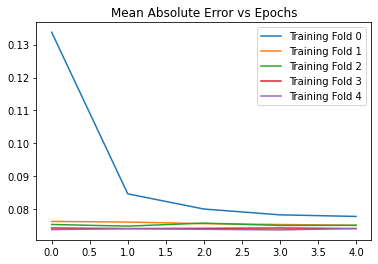

In [42]:
plot.title('Mean Absolute Error vs Epochs')
for i in range(5):
    plot.plot(model_history[i].history['mae'], label=('Training Fold ' + str(i)))
plot.legend()
plot.show()

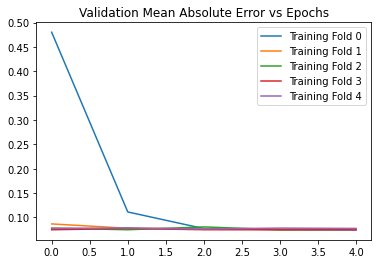

In [43]:
plot.title('Validation Mean Absolute Error vs Epochs')
for i in range(5):
    plot.plot(model_history[i].history['val_mae'], label=('Training Fold ' + str(i)))
plot.legend()
plot.show()

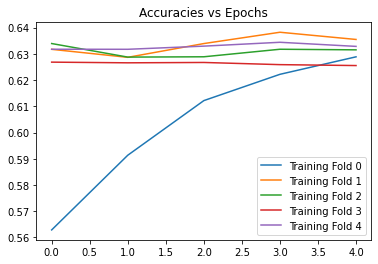

In [44]:
plot.title('Accuracies vs Epochs')
for i in range(5):
    plot.plot(model_history[i].history['acc'], label=('Training Fold ' + str(i)))
plot.legend()
plot.show()

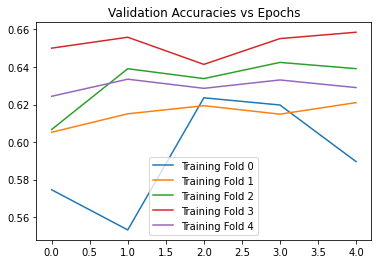

In [45]:
plot.title('Validation Accuracies vs Epochs')
for i in range(5):
    plot.plot(model_history[i].history['val_acc'], label=('Training Fold ' + str(i)))
plot.legend()
plot.show()

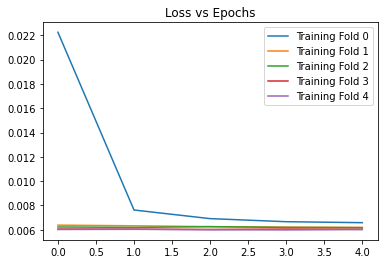

In [46]:
plot.title('Loss vs Epochs')
for i in range(5):
    plot.plot(model_history[i].history['loss'], label=('Training Fold ' + str(i)))
plot.legend()
plot.show()

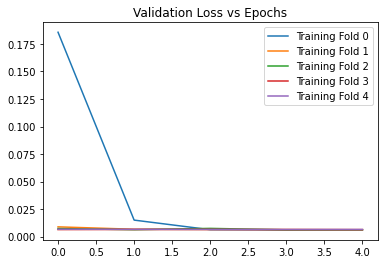

In [47]:
plot.title('Validation Loss vs Epochs')
for i in range(5):
    plot.plot(model_history[i].history['val_loss'], label=('Training Fold ' + str(i)))
plot.legend()
plot.show()

### 8 Predict

In [48]:
pred = model.predict(test_x, batch_size=16)
pred.shape

10/10 [==============================] - 27s 3s/step


(150, 224, 224, 2)

### 9 Show results

In [49]:
from skimage.color import rgb2gray

In [50]:
def show_results(x, y_pred, y_des):

    fig = plot.figure(figsize=( 10, 5))
    
    rows = 1
    columns = 3

    img0 = np.zeros((224, 224, 3))
    img1 = np.zeros((224, 224, 3))
    img2 = np.zeros((224, 224, 3))

    x = np.squeeze(x)
    y_pred = y_pred*128
    y_des = y_des*128

    img0[:,:,0] = x
    img0 = lab2rgb(img0)
    img0 = np.float32(img0)
    
    img1[:,:,0] = x
    img1[:,:,1] = y_pred[:,:,0]
    img1[:,:,2] = y_pred[:,:,1]
    img1 = lab2rgb(img1)
    img1 = np.float32(img1)

    img2[:,:,0] = x
    img2[:,:,1] = y_des[:,:,0]
    img2[:,:,2] = y_des[:,:,1]
    img2 = lab2rgb(img2)
    img2 = np.float32(img2)

    fig.add_subplot(rows, columns, 1)

    plot.imshow(img0)
    plot.axis('off')
    plot.title('Grayscale')

    fig.add_subplot(rows, columns, 2)

    plot.imshow(img1)
    plot.axis('off')
    plot.title('Predicted')

    fig.add_subplot(rows, columns, 3)

    plot.imshow(img2)
    plot.axis('off')
    plot.title('Actual')

    plot.show()

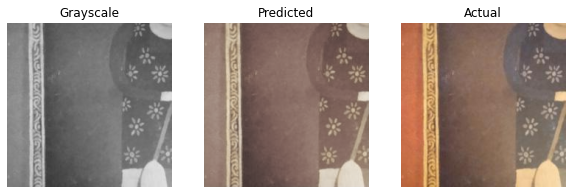

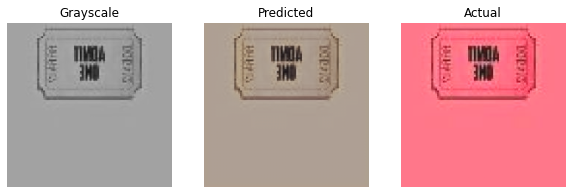

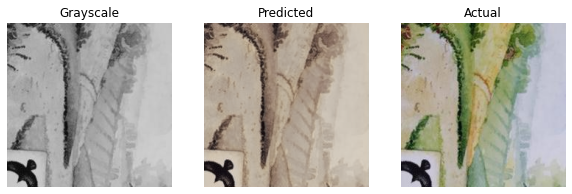

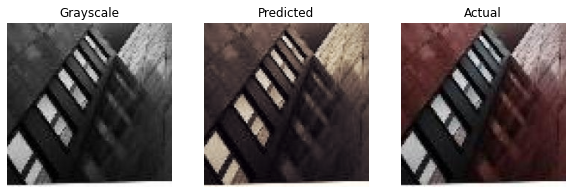

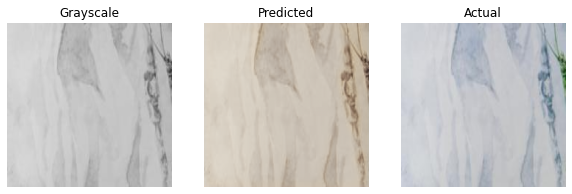

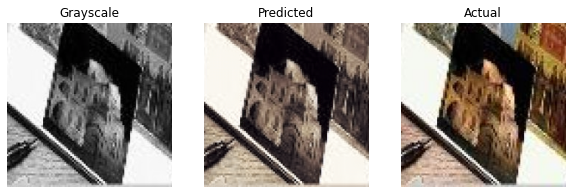

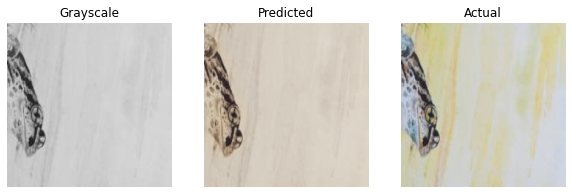

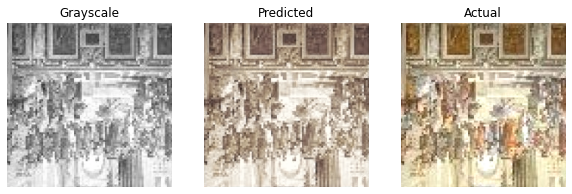

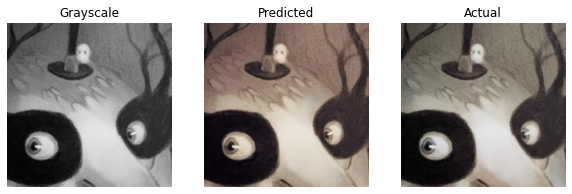

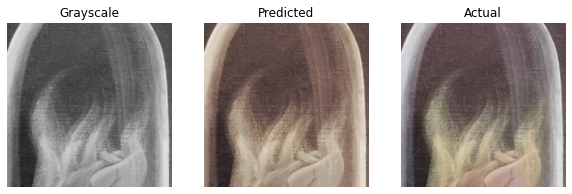

In [51]:
for i in range(10):
    show_results(test_x[i], pred[i], test_y[i])